In [1]:
# Import standard modules.
import sys

# Import supplemental modules.
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# Import project modules
sys.path.insert(0, '/Users/winteel1/research/src/pinn/tsyganenko_neutral_current_sheet/pinn')
import problems.tsyganenko_ncs.tsyganenko_ncs as tncs

In [2]:
# Notes on notation

# All citations are from:

# Tsyganenko et al, Ann. Geophys., 33, 1–11, 2015
# doi:10.5194/angeo-33-1-2015

# The model is in cylindrical Solar Magnetic (SM) coordinates, centered
# on the Earth.

# PpCcLl = page, column, line

# Notes on variable names:
# Names in all-caps represent 2-D arrays used for surface plotting.
# These are typically created by numpy.meshgrid().

# rho = Radius in cylindrical Solar Magetic (SM) coordinates (R_E)
# phi = Longitude in cylindrical Solar Magetic (SM) coordinates (radians)
# Zs = Height of current sheet surface above SM XY plane (R_E)
# psi = Tilt angle of Earth dipole relative to Sun-Earth line (radians)
# P = Solar wind dynamic (ram) pressure (nP)
# By = y-component of solar wind (nT)
# Bz = z-component of solar wind (nT)

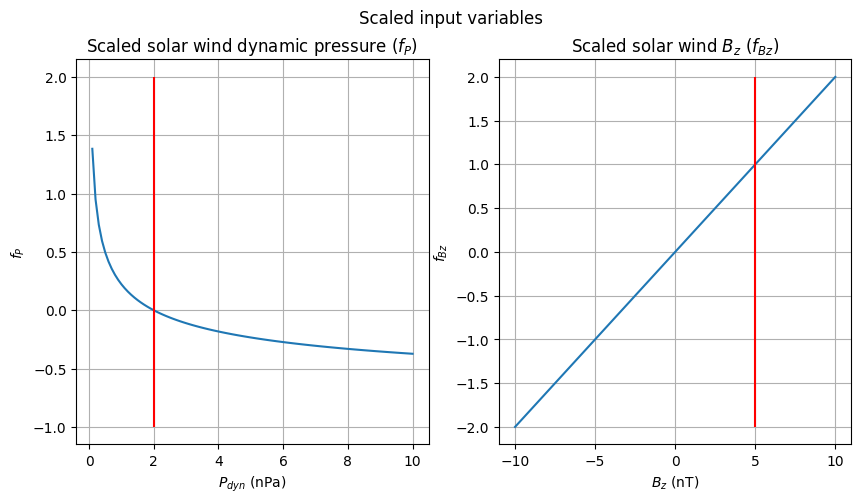

In [3]:
# Plot the scaling functions for the input variables.

# Figure parameters
figsize = (10, 5)
NROWS = 1
NCOLS = 2
MEAN_VALUE_COLOR = 'red'

# Plot domain and range limits.
Pmin, Pmax, nP = 0, 10, 101
fPmin, fPmax = -1.0, 2.0
Bzmin, Bzmax, nBz = -2*tncs.Bz0, 2*tncs.Bz0, 101
fBzmin, fBzmax = -2.0, 2.0

# Create the data for plotting the scaled pressure.
P = np.linspace(Pmin, Pmax, nP)[1:]  # Skip P = 0
fP = tncs.fP_empirical(P)

# Create the data for plotting the scaled Bz.
Bz = np.linspace(Bzmin, Bzmax, nBz)
fBz = tncs.fBz_empirical(Bz)

# Create the figure.
fig = plt.figure(figsize=figsize)
fig.suptitle('Scaled input variables')
gs = mpl.gridspec.GridSpec(NROWS, NCOLS)

# Left plot: Pressure scaling (Equation 10)
ax = fig.add_subplot(gs[0])
ax.grid()
ax.set_xlabel("$P_{dyn}$ (nPa)")
ax.set_ylabel("$f_P$")
ax.set_title("Scaled solar wind dynamic pressure ($f_P$)")
ax.plot(P, fP)
# Plot vertical line at scale value.
ax.vlines(tncs.Pmean, fPmin, fPmax, color=MEAN_VALUE_COLOR)

# Right plot: Bz scaling (Equation 10)
ax = fig.add_subplot(gs[1])
ax.grid()
ax.set_xlabel("$B_z$ (nT)")
ax.set_ylabel("$f_{Bz}$")
ax.set_title("Scaled solar wind $B_z$ ($f_{Bz}$)")
ax.plot(Bz, fBz)
# Plot vertical line at scale value.
ax.vlines(tncs.Bz0, fBzmin, fBzmax, color=MEAN_VALUE_COLOR)

# Show the figure.
plt.show()

In [4]:
# Create evaluation grids of fP and fBz.

# Define domains for scaled pressure and Bz.
fPmin, fPmax, nfP = -2.0, 2.0, 101
fBzmin, fBzmax, nfBz = -2.0, 2.0, 101

# All calcuations at 0 longitude.
phi = 0.0

# Compute the grid points.
fP = np.linspace(fPmin, fPmax, nfP)
fBz = np.linspace(fBzmin, fBzmax, nfBz)

# Make a meshgrid for evaluation.
# Both are shape (nfBz, nfP).
# The nfBz rows of FP are the nfP values of fP.
# The nfP columns of FBZ are the nfBz values of fBz.
FP, FBZ = np.meshgrid(fP, fBz)

# Create the matching phi array.
PHI = np.full(FP.shape, phi)

In [5]:
# Compute tick marks and labels imshow() plot in (fP, fBz) space.
# Tick positions are in pixel coordinates.
N_X_TICKS = 5
x_tick_pos = np.linspace(0, nfP - 1, N_X_TICKS)
x_tick_labels = ["%.1f" % (fPmin + x/(nfP - 1)*(fPmax - fPmin)) for x in x_tick_pos]
N_Y_TICKS = 5
y_tick_pos = np.linspace(0, nfBz - 1, N_Y_TICKS)
y_tick_labels = ["%.1f" % (fBzmin + y/(nfBz - 1)*(fBzmax - fBzmin)) for y in y_tick_pos]

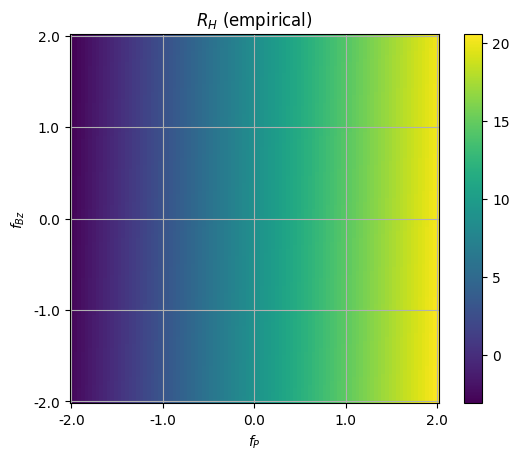

In [6]:
# Plot the empirical equation for RH(fP, fBz, phi) (Equation 4).

# Compute the value of RH at each point.
RH = tncs.RH_empirical(FP, FBZ, PHI)
# Shape is (nfBz, nfP)

# Plot as image.
fig = plt.figure()
ax = fig.add_subplot()
im = ax.imshow(RH, origin='lower')
fig.colorbar(im)

# Decorate the plot.
ax.grid()
ax.set_title("$R_H$ (empirical)")
ax.set_xlabel("$f_P$")
ax.set_ylabel("$f_{Bz}$")
ax.set_xticks(x_tick_pos)
ax.set_xticklabels(x_tick_labels)
ax.set_yticks(y_tick_pos)
ax.set_yticklabels(y_tick_labels)

# Show the figure.
plt.show()

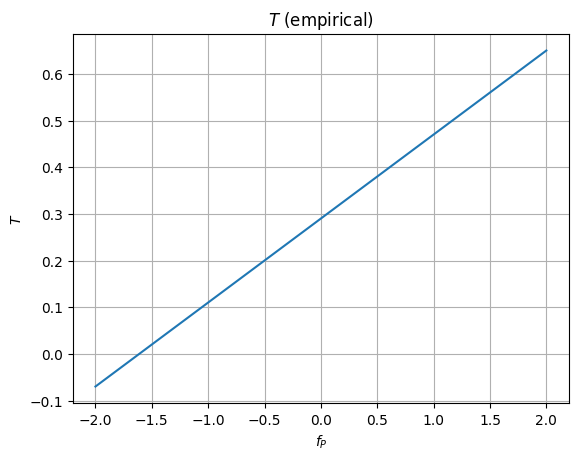

In [7]:
# Plot the empirical equation for T(fP) (Equation 5).

# Compute the T value at each point.
T = tncs.T_empirical(fP, fBz, phi)

# Create the plot.
fig = plt.figure()
ax = fig.add_subplot()
ax.grid()
ax.set_xlabel("$f_P$")
ax.set_ylabel("$T$")
ax.set_title("$T$ (empirical)")
ax.plot(fP, T)

# Show the plot.
plt.show()

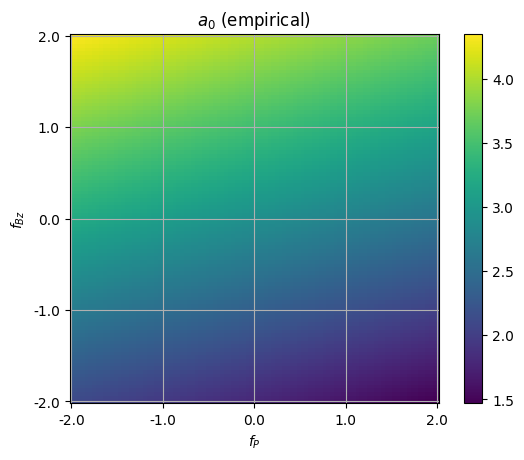

In [8]:
# Plot the empirical equation for a0(fP, fBz, phi) (Equation 6).

# Compute the value of a0 at each point.
A0 = tncs.a0_empirical(FP, FBZ, PHI)
# Shape is (nfBz, nfP)

# Plot as image.
fig = plt.figure()
ax = fig.add_subplot()
im = ax.imshow(A0, origin='lower')
fig.colorbar(im)

# Decorate the plot.
ax.grid()
ax.set_title("$a_0$ (empirical)")
ax.set_xlabel("$f_P$")
ax.set_ylabel("$f_{Bz}$")
ax.set_xticks(x_tick_pos)
ax.set_xticklabels(x_tick_labels)
ax.set_yticks(y_tick_pos)
ax.set_yticklabels(y_tick_labels)

# Show the figure.
plt.show()

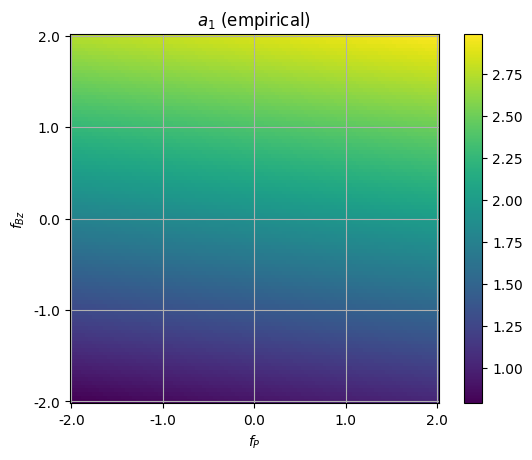

In [9]:
# Plot the empirical equation for a1(fP, fBz, phi) (Equation 7).

# Compute the value of a1 at each point.
A1 = tncs.a1_empirical(FP, FBZ, PHI)
# Shape is (nfBz, nfP)

# Plot as image.
fig = plt.figure()
ax = fig.add_subplot()
im = ax.imshow(A1, origin='lower')
fig.colorbar(im)

# Decorate the plot.
ax.grid()
ax.set_title("$a_1$ (empirical)")
ax.set_xlabel("$f_P$")
ax.set_ylabel("$f_{Bz}$")
ax.set_xticks(x_tick_pos)
ax.set_xticklabels(x_tick_labels)
ax.set_yticks(y_tick_pos)
ax.set_yticklabels(y_tick_labels)

# Show the figure.
plt.show()

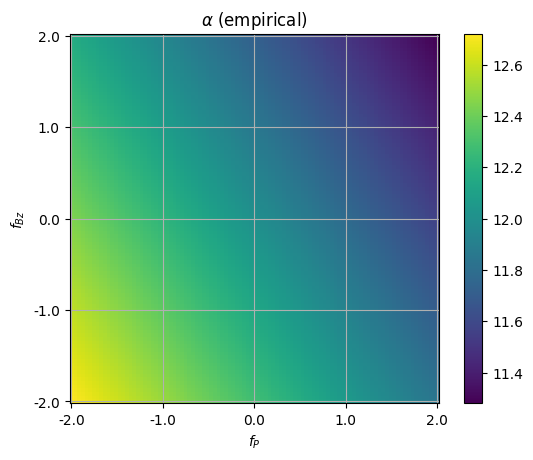

In [10]:
# Plot the empirical equation for alpha(fP, fBz, phi) (Equation 8).

# Compute the value of alpha at each point.
ALPHA = tncs.alpha_empirical(FP, FBZ, PHI)
# Shape is (nfBz, nfP)

# Plot as image.
fig = plt.figure()
ax = fig.add_subplot()
im = ax.imshow(ALPHA, origin='lower')
fig.colorbar(im)

# Decorate the plot.
ax.grid()
ax.set_title(r"$\alpha$ (empirical)")
ax.set_xlabel("$f_P$")
ax.set_ylabel("$f_{Bz}$")
ax.set_xticks(x_tick_pos)
ax.set_xticklabels(x_tick_labels)
ax.set_yticks(y_tick_pos)
ax.set_yticklabels(y_tick_labels)

# Show the figure.
plt.show()

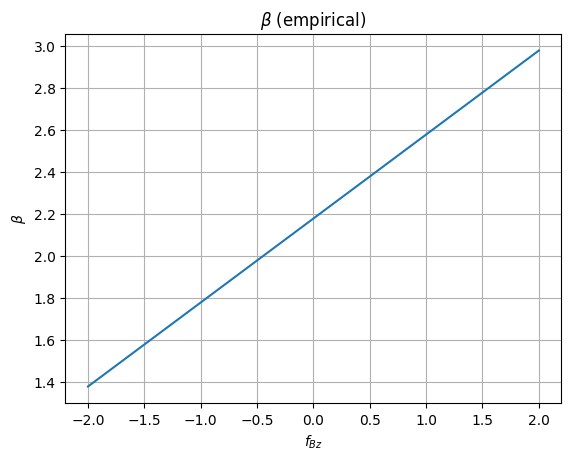

In [11]:
# Plot the empirical equation for beta(fBz) (Equation 9).

# Compute the T value at each point.
beta = tncs.beta_empirical(fP, fBz, phi)

# Create the plot.
fig = plt.figure()
ax = fig.add_subplot()
ax.grid()
ax.set_xlabel("$f_{Bz}$")
ax.set_ylabel(r"$\beta$")
ax.set_title(r"$\beta$ (empirical)")
ax.plot(fP, beta)

# Show the plot.
plt.show()

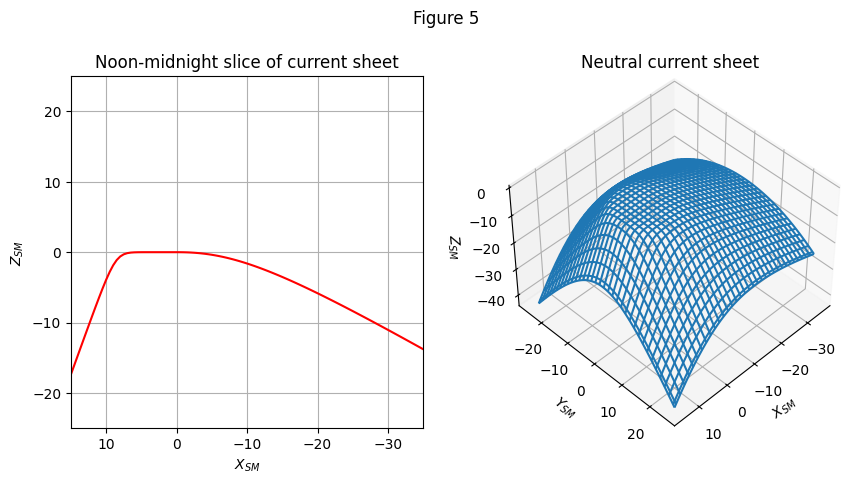

In [12]:
# Replicate Figure 5.

# Domain limits and point spacing
x_SM_min, x_SM_max, nx_SM = -35.0, 15.0, 101
y_SM_min, y_SM_max, ny_SM = -25.0, 25.0, 101
z_SM_min, z_SM_max = -25.0, 25.0  # No grid

# Compute the grid locations.
x_SM = np.linspace(x_SM_min, x_SM_max, nx_SM)
y_SM = np.linspace(y_SM_min, y_SM_max, ny_SM)

# Create the meshgrids of evaluation points in Cartesian
# and cylindrical SM coordinates.
X_SM, Y_SM = np.meshgrid(x_SM, y_SM)
RHO_SM = np.sqrt(X_SM**2 + Y_SM**2)
PHI_SM = np.arctan2(Y_SM, X_SM)

# Create arrays for the solar wind data.
P_dyn = 2.0
By_IMF = 0.0
Bz_IMF = 0.0
psi = np.radians(30)
P = np.full(X_SM.shape, P_dyn)
BY = np.full(X_SM.shape, By_IMF)
BZ = np.full(X_SM.shape, Bz_IMF)
PSI = np.full(X_SM.shape, psi)

# Evaluate the NCS height in the SM frame at each grid point.
ZS_SM = tncs.Zs_empirical(P, BY, BZ, PSI, RHO_SM, PHI_SM)

# Create the figure.
figsize = (10, 5)
NROWS = 1
NCOLS = 2
fig = plt.figure(figsize=figsize)
fig.suptitle('Figure 5')
gs = mpl.gridspec.GridSpec(NROWS, NCOLS)

# Left plot: XZ (SM) plane, noon-midnight slice
i = ny_SM//2  # Index of noon-midnight slice
X_SM_NOON_MIDNIGHT_SLICE = X_SM[i]
Z_SM_NOON_MIDNIGHT_SLICE = ZS_SM[i]
ax = fig.add_subplot(gs[0])
plt.plot(X_SM_NOON_MIDNIGHT_SLICE, Z_SM_NOON_MIDNIGHT_SLICE, color='red')
ax.grid()
ax.set_aspect('equal')
ax.set_title('Noon-midnight slice of current sheet')
ax.set_xlabel("$X_{SM}$")
ax.set_ylabel("$Z_{SM}$")
ax.set_xbound(x_SM_min, x_SM_max)
ax.set_ybound(z_SM_min, z_SM_max)
ax.invert_xaxis()  # X_SM increases to left, toward Sun

# Right plot: current sheet surface in SM coordinates
ax = fig.add_subplot(gs[1], projection='3d')
ax.plot_wireframe(X_SM, Y_SM, ZS_SM)
ax.set_title('Neutral current sheet')
ax.set_xlabel(r'$X_{SM}$')
ax.set_ylabel(r'$Y_{SM}$')
ax.set_zlabel(r'$Z_{SM}$')

# Set the viewing angles in degrees.
elev, azim, roll = 45.0, 45.0, 0
ax.view_init(elev=elev, azim=azim, roll=roll)

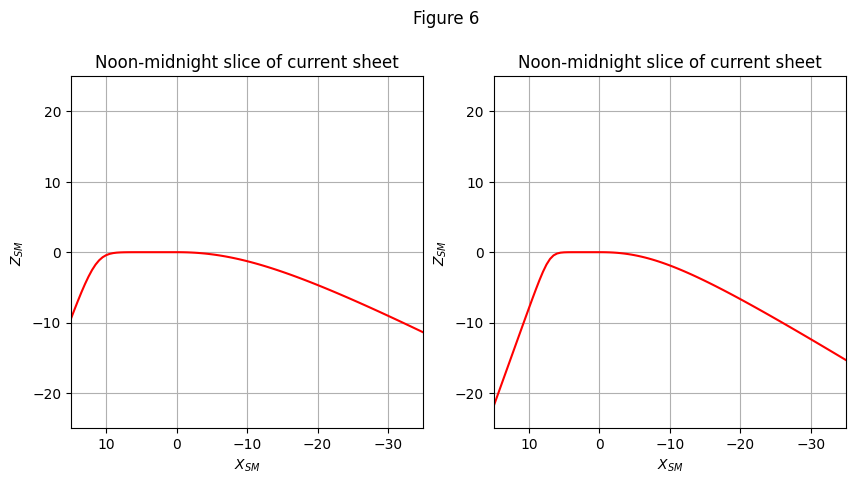

In [13]:
# Replicate Figure 6.

# Domain limits and point spacing
x_SM_min, x_SM_max, nx_SM = -35.0, 15.0, 101
y_SM_min, y_SM_max, ny_SM = -25.0, 25.0, 101
z_SM_min, z_SM_max = -25.0, 25.0  # No grid

# Compute the grid locations.
x_SM = np.linspace(x_SM_min, x_SM_max, nx_SM)
y_SM = np.linspace(y_SM_min, y_SM_max, ny_SM)

# Create the meshgrids of evaluation points in Cartesian
# and cylindrical SM coordinates.
X_SM, Y_SM = np.meshgrid(x_SM, y_SM)
RHO_SM = np.sqrt(X_SM**2 + Y_SM**2)
PHI_SM = np.arctan2(Y_SM, X_SM)

# Create the figure.
figsize = (10, 5)
NROWS = 1
NCOLS = 2
fig = plt.figure(figsize=figsize)
fig.suptitle('Figure 6')
gs = mpl.gridspec.GridSpec(NROWS, NCOLS)

# Left plot: XZ (SM) plane, noon-midnight slice

# Create arrays for the solar wind data.
P_dyn = 0.5
By_IMF = 0.0
Bz_IMF = 0.0
psi = np.radians(30)
P = np.full(X_SM.shape, P_dyn)
BY = np.full(X_SM.shape, By_IMF)
BZ = np.full(X_SM.shape, Bz_IMF)
PSI = np.full(X_SM.shape, psi)

# Evaluate the NCS height in the SM frame at each grid point.
ZS_SM = tncs.Zs_empirical(P, BY, BZ, PSI, RHO_SM, PHI_SM)
i = ny_SM//2  # Index of noon-midnight slice
X_SM_NOON_MIDNIGHT_SLICE = X_SM[i]
Z_SM_NOON_MIDNIGHT_SLICE = ZS_SM[i]
ax = fig.add_subplot(gs[0])
plt.plot(X_SM_NOON_MIDNIGHT_SLICE, Z_SM_NOON_MIDNIGHT_SLICE, color='red')
ax.grid()
ax.set_aspect('equal')
ax.set_title('Noon-midnight slice of current sheet')
ax.set_xlabel("$X_{SM}$")
ax.set_ylabel("$Z_{SM}$")
ax.set_xbound(x_SM_min, x_SM_max)
ax.set_ybound(z_SM_min, z_SM_max)
ax.invert_xaxis()  # X_SM increases to left, toward Sun

# Right plot: XZ (SM) plane, noon-midnight slice

# Create arrays for the solar wind data.
P_dyn = 6.0
By_IMF = 0.0
Bz_IMF = 0.0
psi = np.radians(30)
P = np.full(X_SM.shape, P_dyn)
BY = np.full(X_SM.shape, By_IMF)
BZ = np.full(X_SM.shape, Bz_IMF)
PSI = np.full(X_SM.shape, psi)

# Evaluate the NCS height in the SM frame at each grid point.
ZS_SM = tncs.Zs_empirical(P, BY, BZ, PSI, RHO_SM, PHI_SM)
i = ny_SM//2  # Index of noon-midnight slice
X_SM_NOON_MIDNIGHT_SLICE = X_SM[i]
Z_SM_NOON_MIDNIGHT_SLICE = ZS_SM[i]
ax = fig.add_subplot(gs[1])
plt.plot(X_SM_NOON_MIDNIGHT_SLICE, Z_SM_NOON_MIDNIGHT_SLICE, color='red')
ax.grid()
ax.set_aspect('equal')
ax.set_title('Noon-midnight slice of current sheet')
ax.set_xlabel("$X_{SM}$")
ax.set_ylabel("$Z_{SM}$")
ax.set_xbound(x_SM_min, x_SM_max)
ax.set_ybound(y_SM_min, y_SM_max)
ax.invert_xaxis()  # X_SM increases to left, toward Sun

# Show the figure.
plt.show()

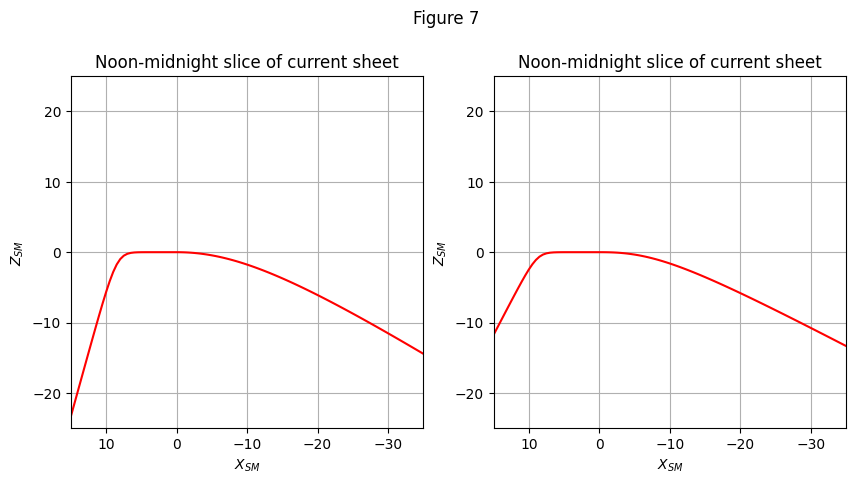

In [14]:
# Replicate Figure 7.

# Domain limits and point spacing
x_SM_min, x_SM_max, nx_SM = -35.0, 15.0, 101
y_SM_min, y_SM_max, ny_SM = -25.0, 25.0, 101
z_SM_min, z_SM_max = -25.0, 25.0  # No grid

# Compute the grid locations.
x_SM = np.linspace(x_SM_min, x_SM_max, nx_SM)
y_SM = np.linspace(y_SM_min, y_SM_max, ny_SM)

# Create the meshgrids of evaluation points in Cartesian
# and cylindrical SM coordinates.
X_SM, Y_SM = np.meshgrid(x_SM, y_SM)
RHO_SM = np.sqrt(X_SM**2 + Y_SM**2)
PHI_SM = np.arctan2(Y_SM, X_SM)

# Create the figure.
figsize = (10, 5)
NROWS = 1
NCOLS = 2
fig = plt.figure(figsize=figsize)
fig.suptitle('Figure 7')
gs = mpl.gridspec.GridSpec(NROWS, NCOLS)

# Left plot: XZ (SM) plane, noon-midnight slice

# Create arrays for the solar wind data.
P_dyn = 2.0
By_IMF = 0.0
Bz_IMF = 7.0
psi = np.radians(30)
P = np.full(X_SM.shape, P_dyn)
BY = np.full(X_SM.shape, By_IMF)
BZ = np.full(X_SM.shape, Bz_IMF)
PSI = np.full(X_SM.shape, psi)

# Evaluate the NCS height in the SM frame at each grid point.
ZS_SM = tncs.Zs_empirical(P, BY, BZ, PSI, RHO_SM, PHI_SM)
i = ny_SM//2  # Index of noon-midnight slice
X_SM_NOON_MIDNIGHT_SLICE = X_SM[i]
Z_SM_NOON_MIDNIGHT_SLICE = ZS_SM[i]
ax = fig.add_subplot(gs[0])
plt.plot(X_SM_NOON_MIDNIGHT_SLICE, Z_SM_NOON_MIDNIGHT_SLICE, color='red')
ax.grid()
ax.set_aspect('equal')
ax.set_title('Noon-midnight slice of current sheet')
ax.set_xlabel("$X_{SM}$")
ax.set_ylabel("$Z_{SM}$")
ax.set_xbound(x_SM_min, x_SM_max)
ax.set_ybound(z_SM_min, z_SM_max)
ax.invert_xaxis()  # X_SM increases to left, toward Sun

# Right plot: XZ (SM) plane, noon-midnight slice

# Create arrays for the solar wind data.
P_dyn = 2.0
By_IMF = 0.0
Bz_IMF = -7.0
psi = np.radians(30)
P = np.full(X_SM.shape, P_dyn)
BY = np.full(X_SM.shape, By_IMF)
BZ = np.full(X_SM.shape, Bz_IMF)
PSI = np.full(X_SM.shape, psi)

# Evaluate the NCS height in the SM frame at each grid point.
ZS_SM = tncs.Zs_empirical(P, BY, BZ, PSI, RHO_SM, PHI_SM)
i = ny_SM//2  # Index of noon-midnight slice
X_SM_NOON_MIDNIGHT_SLICE = X_SM[i]
Z_SM_NOON_MIDNIGHT_SLICE = ZS_SM[i]
ax = fig.add_subplot(gs[1])
plt.plot(X_SM_NOON_MIDNIGHT_SLICE, Z_SM_NOON_MIDNIGHT_SLICE, color='red')
ax.grid()
ax.set_aspect('equal')
ax.set_title('Noon-midnight slice of current sheet')
ax.set_xlabel("$X_{SM}$")
ax.set_ylabel("$Z_{SM}$")
ax.set_xbound(x_SM_min, x_SM_max)
ax.set_ybound(y_SM_min, y_SM_max)
ax.invert_xaxis()  # X_SM increases to left, toward Sun

# Show the figure.
plt.show()

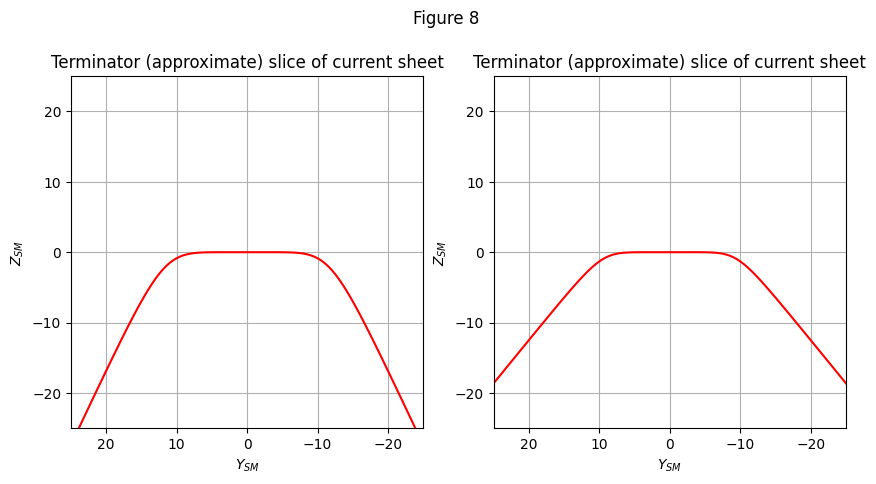

In [15]:
# Replicate Figure 8.

# Domain limits and point spacing
x_SM_min, x_SM_max, nx_SM = -35.0, 15.0, 101
y_SM_min, y_SM_max, ny_SM = -25.0, 25.0, 101
z_SM_min, z_SM_max = -25.0, 25.0  # No grid

# Compute the grid locations.
x_SM = np.linspace(x_SM_min, x_SM_max, nx_SM)
y_SM = np.linspace(y_SM_min, y_SM_max, ny_SM)

# Create the meshgrids of evaluation points in Cartesian
# and cylindrical SM coordinates.
X_SM, Y_SM = np.meshgrid(x_SM, y_SM)
RHO_SM = np.sqrt(X_SM**2 + Y_SM**2)
PHI_SM = np.arctan2(Y_SM, X_SM)

# Create the figure.
figsize = (10, 5)
NROWS = 1
NCOLS = 2
fig = plt.figure(figsize=figsize)
fig.suptitle('Figure 8')
gs = mpl.gridspec.GridSpec(NROWS, NCOLS)

# Left plot: XZ (SM) plane, ~terminator slice
# This plot is looking sunward from the magnetotail.

# Create arrays for the solar wind data.
P_dyn = 2.0
By_IMF = 0.0
Bz_IMF = 7.0
psi = np.radians(30)
P = np.full(X_SM.shape, P_dyn)
BY = np.full(X_SM.shape, By_IMF)
BZ = np.full(X_SM.shape, Bz_IMF)
PSI = np.full(X_SM.shape, psi)

# Evaluate the NCS height in the SM frame at each grid point.
ZS_SM = tncs.Zs_empirical(P, BY, BZ, PSI, RHO_SM, PHI_SM)
i = int((0.0 - x_SM_min)/(x_SM_max - x_SM_min)*nx_SM)  # Index of X_SM=0 slice
Y_SM_TERMINATOR_SLICE = Y_SM[..., i]
Z_SM_TERMINATOR_SLICE = ZS_SM[..., i]
ax = fig.add_subplot(gs[0])
plt.plot(Y_SM_TERMINATOR_SLICE, Z_SM_TERMINATOR_SLICE, color='red')
ax.grid()
ax.set_aspect('equal')
ax.set_title("Terminator (approximate) slice of current sheet")
ax.set_xlabel("$Y_{SM}$")
ax.set_ylabel("$Z_{SM}$")
ax.set_xbound(y_SM_min, y_SM_max)
ax.set_ybound(z_SM_min, z_SM_max)
ax.invert_xaxis()  # Y_SM increases to left, against Earth orbit.

# Right plot: XZ (SM) plane, X_SM = 0 slice
# This plot is looking sunward from the magnetotail.

# Create arrays for the solar wind data.
P_dyn = 2.0
By_IMF = 0.0
Bz_IMF = -7.0
psi = np.radians(30)
P = np.full(X_SM.shape, P_dyn)
BY = np.full(X_SM.shape, By_IMF)
BZ = np.full(X_SM.shape, Bz_IMF)
PSI = np.full(X_SM.shape, psi)

# Evaluate the NCS height in the SM frame at each grid point.
ZS_SM = tncs.Zs_empirical(P, BY, BZ, PSI, RHO_SM, PHI_SM)
i = int((0.0 - x_SM_min)/(x_SM_max - x_SM_min)*nx_SM)  # Index of X_SM=0 slice
Y_SM_TERMINATOR_SLICE = Y_SM[..., i]
Z_SM_TERMINATOR_SLICE = ZS_SM[..., i]
ax = fig.add_subplot(gs[1])
plt.plot(Y_SM_TERMINATOR_SLICE, Z_SM_TERMINATOR_SLICE, color='red')
ax.grid()
ax.set_aspect('equal')
ax.set_title("Terminator (approximate) slice of current sheet")
ax.set_xlabel("$Y_{SM}$")
ax.set_ylabel("$Z_{SM}$")
ax.set_xbound(y_SM_min, y_SM_max)
ax.set_ybound(z_SM_min, z_SM_max)
ax.invert_xaxis()  # Y_SM increases to left, against Earth orbit.

# Show the figure.
plt.show()

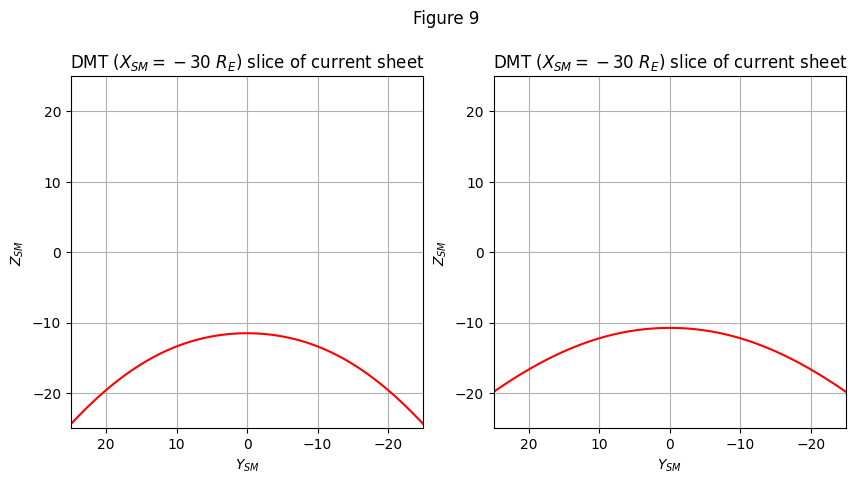

In [19]:
# Replicate Figure 9.

# Domain limits and point spacing
x_SM_min, x_SM_max, nx_SM = -35.0, 15.0, 101
y_SM_min, y_SM_max, ny_SM = -25.0, 25.0, 101
z_SM_min, z_SM_max = -25.0, 25.0  # No grid

# Compute the grid locations.
x_SM = np.linspace(x_SM_min, x_SM_max, nx_SM)
y_SM = np.linspace(y_SM_min, y_SM_max, ny_SM)

# Create the meshgrids of evaluation points in Cartesian
# and cylindrical SM coordinates.
X_SM, Y_SM = np.meshgrid(x_SM, y_SM)
RHO_SM = np.sqrt(X_SM**2 + Y_SM**2)
PHI_SM = np.arctan2(Y_SM, X_SM)

# Create the figure.
figsize = (10, 5)
NROWS = 1
NCOLS = 2
fig = plt.figure(figsize=figsize)
fig.suptitle('Figure 9')
gs = mpl.gridspec.GridSpec(NROWS, NCOLS)

# Left plot: XZ (SM) plane, distant magnetotail (DMT) slice
# This plot is looking sunward from the magnetotail.

# Create arrays for the solar wind data.
P_dyn = 2.0
By_IMF = 0.0
Bz_IMF = 7.0
psi = np.radians(30)
P = np.full(X_SM.shape, P_dyn)
BY = np.full(X_SM.shape, By_IMF)
BZ = np.full(X_SM.shape, Bz_IMF)
PSI = np.full(X_SM.shape, psi)

# Evaluate the NCS height in the SM frame at each grid point.
ZS_SM = tncs.Zs_empirical(P, BY, BZ, PSI, RHO_SM, PHI_SM)
i = int((-30.0 - x_SM_min)/(x_SM_max - x_SM_min)*nx_SM)  # Index of DMT slice
Y_SM_DMT_SLICE = Y_SM[..., i]
Z_SM_DMT_SLICE = ZS_SM[..., i]
ax = fig.add_subplot(gs[0])
plt.plot(Y_SM_DMT_SLICE, Z_SM_DMT_SLICE, color='red')
ax.grid()
ax.set_aspect('equal')
ax.set_title("DMT ($X_{SM} = -30$ $R_E$) slice of current sheet")
ax.set_xlabel("$Y_{SM}$")
ax.set_ylabel("$Z_{SM}$")
ax.set_xbound(y_SM_min, y_SM_max)
ax.set_ybound(z_SM_min, z_SM_max)
ax.invert_xaxis()  # Y_SM increases to left, against Earth orbit.

# Right plot: XZ (SM) plane, DMT slice
# This plot is looking sunward from the magnetotail.

# Create arrays for the solar wind data.
P_dyn = 2.0
By_IMF = 0.0
Bz_IMF = -7.0
psi = np.radians(30)
P = np.full(X_SM.shape, P_dyn)
BY = np.full(X_SM.shape, By_IMF)
BZ = np.full(X_SM.shape, Bz_IMF)
PSI = np.full(X_SM.shape, psi)

# Evaluate the NCS height in the SM frame at each grid point.
ZS_SM = tncs.Zs_empirical(P, BY, BZ, PSI, RHO_SM, PHI_SM)
i = int((-30.0 - x_SM_min)/(x_SM_max - x_SM_min)*nx_SM)  # Index of DMT slice
Y_SM_DMT_SLICE = Y_SM[..., i]
Z_SM_DMT_SLICE = ZS_SM[..., i]
ax = fig.add_subplot(gs[1])
plt.plot(Y_SM_DMT_SLICE, Z_SM_DMT_SLICE, color='red')
ax.grid()
ax.set_aspect('equal')
ax.set_title("DMT ($X_{SM} = -30$ $R_E$) slice of current sheet")
ax.set_xlabel("$Y_{SM}$")
ax.set_ylabel("$Z_{SM}$")
ax.set_xbound(y_SM_min, y_SM_max)
ax.set_ybound(z_SM_min, z_SM_max)
ax.invert_xaxis()  # Y_SM increases to left, against Earth orbit.

# Show the figure.
plt.show()

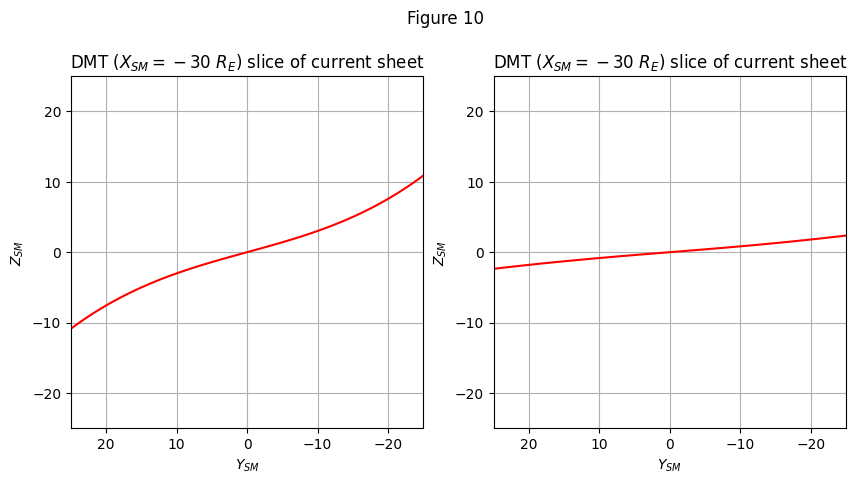

In [29]:
# Replicate Figure 10.

# Domain limits and point spacing
x_SM_min, x_SM_max, nx_SM = -35.0, 15.0, 101
y_SM_min, y_SM_max, ny_SM = -25.0, 25.0, 101
z_SM_min, z_SM_max = -25.0, 25.0  # No grid

# Compute the grid locations.
x_SM = np.linspace(x_SM_min, x_SM_max, nx_SM)
y_SM = np.linspace(y_SM_min, y_SM_max, ny_SM)

# Create the meshgrids of evaluation points in Cartesian
# and cylindrical SM coordinates.
X_SM, Y_SM = np.meshgrid(x_SM, y_SM)
RHO_SM = np.sqrt(X_SM**2 + Y_SM**2)
PHI_SM = np.arctan2(Y_SM, X_SM)

# Create the figure.
figsize = (10, 5)
NROWS = 1
NCOLS = 2
fig = plt.figure(figsize=figsize)
fig.suptitle('Figure 10')
gs = mpl.gridspec.GridSpec(NROWS, NCOLS)

# Left plot: XZ (SM) plane, distant magnetotail (DMT) slice
# This plot is looking sunward from the magnetotail.

# Create arrays for the solar wind data.
P_dyn = 2.0
By_IMF = -7.0
Bz_IMF = 7.0
psi = np.radians(0)
P = np.full(X_SM.shape, P_dyn)
BY = np.full(X_SM.shape, By_IMF)
BZ = np.full(X_SM.shape, Bz_IMF)
PSI = np.full(X_SM.shape, psi)

# Evaluate the NCS height in the SM frame at each grid point.
ZS_SM = tncs.Zs_empirical(P, BY, BZ, PSI, RHO_SM, PHI_SM)
i = int((-30.0 - x_SM_min)/(x_SM_max - x_SM_min)*nx_SM)  # Index of DMT slice
Y_SM_DMT_SLICE = Y_SM[..., i]
Z_SM_DMT_SLICE = ZS_SM[..., i]
ax = fig.add_subplot(gs[0])
plt.plot(Y_SM_DMT_SLICE, Z_SM_DMT_SLICE, color='red')
ax.grid()
ax.set_aspect('equal')
ax.set_title("DMT ($X_{SM} = -30$ $R_E$) slice of current sheet")
ax.set_xlabel("$Y_{SM}$")
ax.set_ylabel("$Z_{SM}$")
ax.set_xbound(y_SM_min, y_SM_max)
ax.set_ybound(z_SM_min, z_SM_max)
ax.invert_xaxis()  # Y_SM increases to left, against Earth orbit.

# Right plot: XZ (SM) plane, DMT slice
# This plot is looking sunward from the magnetotail.

# Create arrays for the solar wind data.
P_dyn = 2.0
By_IMF = -7.0
Bz_IMF = -7.0
psi = np.radians(0)
P = np.full(X_SM.shape, P_dyn)
BY = np.full(X_SM.shape, By_IMF)
BZ = np.full(X_SM.shape, Bz_IMF)
PSI = np.full(X_SM.shape, psi)

# Evaluate the NCS height in the SM frame at each grid point.
ZS_SM = tncs.Zs_empirical(P, BY, BZ, PSI, RHO_SM, PHI_SM)
i = int((-30.0 - x_SM_min)/(x_SM_max - x_SM_min)*nx_SM)  # Index of DMT slice
Y_SM_DMT_SLICE = Y_SM[..., i]
Z_SM_DMT_SLICE = ZS_SM[..., i]
ax = fig.add_subplot(gs[1])
plt.plot(Y_SM_DMT_SLICE, Z_SM_DMT_SLICE, color='red')
ax.grid()
ax.set_aspect('equal')
ax.set_title("DMT ($X_{SM} = -30$ $R_E$) slice of current sheet")
ax.set_xlabel("$Y_{SM}$")
ax.set_ylabel("$Z_{SM}$")
ax.set_xbound(y_SM_min, y_SM_max)
ax.set_ybound(z_SM_min, z_SM_max)
ax.invert_xaxis()  # Y_SM increases to left, against Earth orbit.

# Show the figure.
plt.show()